In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
import shapefile

## K-means clustering

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#### First let's create some random data:

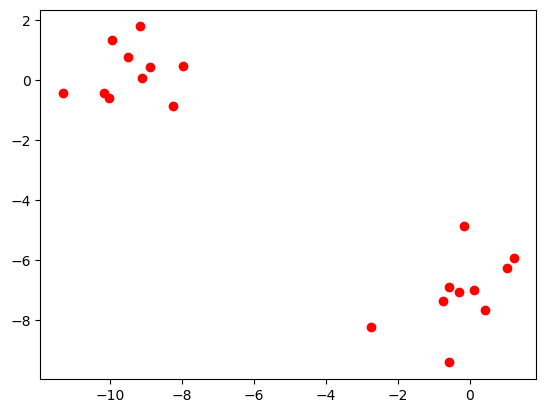

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_features=2, centers=2,n_samples=20,random_state=9)

# display
plt.scatter(X[:,0],X[:,1],c='r')
plt.show()

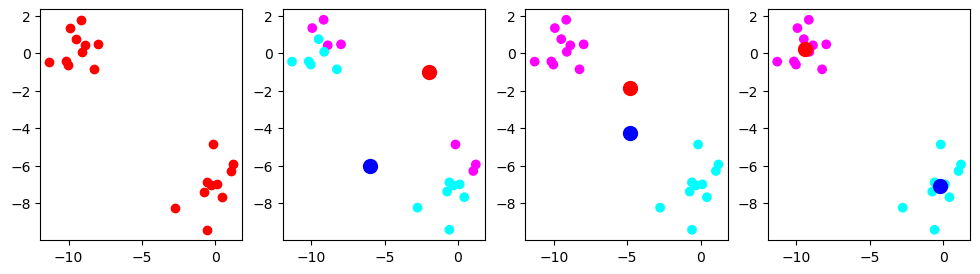

In [3]:
# Let's see what running k-means on this data would look like, step by step:

# arbitrary assignment of centers
cent=np.asarray([[-6,-6],[-2,-1]])
plt.figure(figsize=(12,3))

# first of four panels just has the original data
plt.subplot(1,4,1)
plt.scatter(X[:,0],X[:,1],c="r")

# for each k-means step
for i in range(3):
    
    # show on a separate subplot
    plt.subplot(1,4,i+2)
    
    # compute euclidean distance to each cluster center for each point
    distance_to_cluster_0 = np.sum((X-cent[0,:])**2,axis=1)**0.5
    distance_to_cluster_1 = np.sum((X-cent[1,:])**2,axis=1)**0.5
    
    # compute cluster assignment for each point
    y_t = (distance_to_cluster_0 > distance_to_cluster_1) 
    
    # plot points and centers
    plt.scatter(X[:,0],X[:,1],c=y_t,cmap=plt.cm.cool)
    plt.scatter(cent[0,0],cent[0,1],c="b",s=100)
    plt.scatter(cent[1,0],cent[1,1],c="r",s=100)

    # recompute centers
    cent=np.asarray([[np.sum(X[:,0]*(1-y_t))/(np.sum(1-y_t)),np.sum(X[:,1]*(1-y_t))/np.sum(1-y_t)],
            [np.sum(X[:,0]*(y_t))/np.sum(y_t),np.sum(X[:,1]*(y_t))/np.sum(y_t)]])

# show plots
plt.show()

Cluster assignments: [0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0]

Cluster centers:
 [[-9.43071317  0.2442679 ]
 [-0.23225173 -7.07295204]]

Sum of squared errors: 40.851947251933446


/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


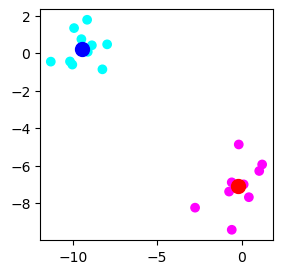

In [4]:
# Use k-means package from sklearn
from sklearn.cluster import KMeans
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(X)

print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

# plot points and cluster assigments
plt.figure(figsize=(3,3))
plt.scatter(X[:,0],X[:,1],c=res.labels_,cmap=plt.cm.cool)
plt.scatter(res.cluster_centers_[0,0],res.cluster_centers_[0,1],c="b",s=100)
plt.scatter(res.cluster_centers_[1,0],res.cluster_centers_[1,1],c="r",s=100)
plt.show()

## Gaussian Mixture Models (EM)

http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

Probabilities of belonging to cluster 1:
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 4.22549367e-58
 1.83399072e-45 1.00000000e+00 5.10884783e-45 1.00000000e+00
 8.84403793e-48 4.78859918e-43 1.66576807e-39 1.57738657e-34
 1.00000000e+00 1.74302711e-47 1.00000000e+00 1.00000000e+00
 5.53228445e-53 1.00000000e+00 1.23718891e-48 1.00000000e+00]

Cluster centers:
 [[-0.23225173 -7.07295204]
 [-9.43071317  0.2442679 ]]

Cluster covariances:
 [[[1.11976176 0.62823388]
  [0.62823388 1.41274852]]

 [[0.8707205  0.12397685]
  [0.12397685 0.68196794]]]

Log-likelihood per sample: -3.437077860830711


/var/folders/qp/9y56mfxx3zq2c_cjbvf9xg_w0000gn/T/ipykernel_46705/2945003820.py:25: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=colors[i])


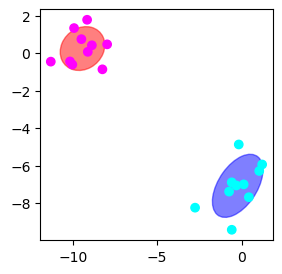

In [5]:
# Use Gaussian mixture models (EM) package from sklearn
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
gmm = GaussianMixture(n_components=2,random_state=100)
res = gmm.fit(X)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(X)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(X))

plt.figure(figsize=(3,3))
splot = plt.subplot(111)

# plot ellipses using mean and covariance matrix for each cluster
colors = ['blue','red']
for i in range(2):
    mean = res.means_[i]
    var = res.covariances_[i]
    v, w = linalg.eigh(var)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=colors[i])
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plot points and cluster assigments
plt.scatter(X[:,0],X[:,1],c=res.predict_proba(X)[:,1],cmap=plt.cm.cool)
plt.show()

### Practice #1.  Using 311 complaints data set to cluster and visualize NYC census tract areas.

In [6]:
import pandas as pd
from sklearn import preprocessing

data311=pd.read_csv("311DataForClustering.csv")
test=preprocessing.normalize(data311.iloc[:,1:])
print(test.shape)
print(data311.head())

(2161, 177)
         geoid  APPLIANCE  Adopt-A-Basket  Air Quality  Animal Abuse  \
0  36061007700          4               0           32             1   
1  36081054200          1               0            0             7   
2  36047003500          2               0            2             1   
3  36047025000          2               0            1             5   
4  36081036100         10               0            1             5   

   Animal Facility - No Permit  Animal in a Park  Asbestos  BEST/Site Safety  \
0                            0                 2         5                 1   
1                            0                 0         0                 0   
2                            0                 0         1                 0   
3                            0                 0         0                 0   
4                            0                 0         0                 0   

   Beach/Pool/Sauna Complaint  ...  VACANT APARTMENT  Vacant Lot  Vending 

In [7]:
# Visualization: example with random cluster assignments
random_clusters = np.random.randint(4,size=len(data311.index))
res=pd.concat([pd.Series(data311.geoid),pd.Series(random_clusters,name='cluster')],axis=1)
res.head()

,geoid,cluster
0,36061007700,2
1,36081054200,1
2,36047003500,1
3,36047025000,3
4,36081036100,2


Reference for this function: 311 Project (Lingjing Wang, Cheng Qian, Constantine Kontokosta, Stanislav Sobolevsky)

https://arxiv.org/pdf/1611.06660.pdf

pip install pyshp

In [8]:
def visualization(result):
    import shapefile
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    #   -- input --
    nyc_geoid=list(data311.geoid.unique())
    sf = shapefile.Reader("nyct2010_16b/nyct2010.shp")
    recs    = sf.records()
    test=pd.DataFrame(recs)
    test.loc[:,'county']=0
    test.loc[test.iloc[:,2]=="Staten Island","county"]="085"
    test.loc[test.iloc[:,2]=="Manhattan","county"]="061"
    test.loc[test.iloc[:,2]=="Brooklyn","county"]="047"
    test.loc[test.iloc[:,2]=="Bronx","county"]="005"
    test.loc[test.iloc[:,2]=="Queens","county"]="081"
    test.loc[:,"geoid"]=0
    test.loc[:,"geoid"]="36"+test.county+test.iloc[:,3].apply(str)

    shapes  = sf.shapes()
    Nshp    = len(shapes)
    cns     = []
    for nshp in range(Nshp):
        cns.append(recs[nshp][1])
    cns = np.array(cns)

    cmap = plt.cm.Spectral(np.linspace(0,1,max(result.iloc[:,-1])+1))

    fig=plt.figure(figsize = (10,10)) 
    fig.add_subplot(111)
    ax = fig.gca() 
    for nshp in range(Nshp):
        if int(test.iloc[nshp,-1]) in nyc_geoid:
            k=result[result.geoid==int(test.iloc[nshp,-1])].iloc[0,-1]
            c=cmap[k][0:3]  
            ptchs   = []
            pts     = np.array(shapes[nshp].points)
            prt     = shapes[nshp].parts
            par     = list(prt) + [pts.shape[0]]
            for pij in range(len(prt)):
                ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
            ax.add_collection(PatchCollection(ptchs,facecolor=c,edgecolor='k', linewidths=.5))
        ax.axis('scaled')
    #ax.set_title("NYC Clustering based on 311 service request data")

    import matplotlib.patches as mpatches
    clum_num=len(result.iloc[:,-1].unique())

    handles=[]
    for t in range(clum_num):
        locals()["patch_{}".format(t)] = mpatches.Patch(color=cmap[t][0:3] , label='Cluster'+str(t+1))
        handles.append(locals()["patch_{}".format(t)])
    #plt.axis('off')
    plt.xticks([], [])
    plt.yticks([],[])
    plt.legend(handles=handles,loc='upper left',prop={'size':8})
    plt.show()

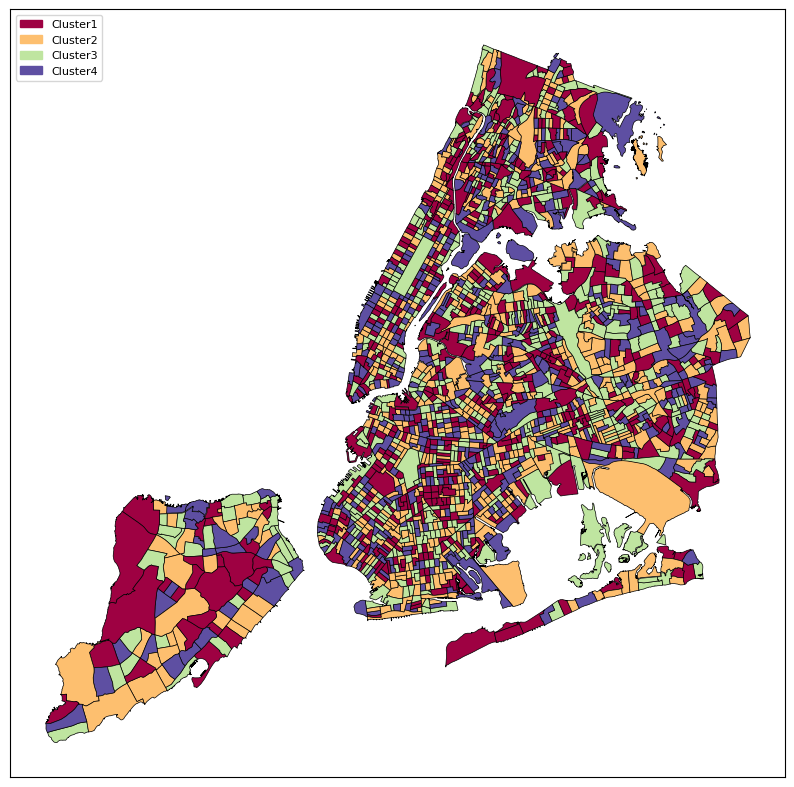

In [9]:
visualization(result=res)

### Now try running k-means with between 2 and 5 clusters.  For each n_clusters, report the impurity (sum of squared errors, also called "inertia") and visualize the results.

In [14]:
# your code here
for Clusters in range(2, 6):
    km = KMeans(random_state=234, n_clusters=Clusters)
    res = km.fit(test)
    
    print(f'For {Clusters} clusters:')
    print('Cluster assignments:', res.labels_)
    
    print('\nSum of squared errors:', res.inertia_)
    

/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For 2 clusters:
Cluster assignments: [0 0 0 ... 0 0 0]

Sum of squared errors: 799.4337243299846


/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For 3 clusters:
Cluster assignments: [0 1 0 ... 1 1 1]

Sum of squared errors: 718.2614956337901


/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For 4 clusters:
Cluster assignments: [2 0 2 ... 0 0 0]

Sum of squared errors: 653.0354141235989


/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For 5 clusters:
Cluster assignments: [2 4 2 ... 4 4 4]

Sum of squared errors: 624.2743232643835


## Hierarchical Clustering

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

(as an alternative, could use sklearn.cluster.AgglomerativeClustering, but not such great visualization.)


In [ ]:
# same randomly generated points as above
from sklearn.datasets import make_blobs
X, y = make_blobs(n_features=2, centers=2,n_samples=20,random_state=9)

Linkage:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

An (n−1) by 4 matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n+i. A cluster with an index less than nn corresponds to one of the nn original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

### Single Linkage

In [15]:
Z_single = linkage(X, 'single')
print(Z_single)

[[14.         19.          0.21629217  2.        ]
 [ 4.          9.          0.31973131  2.        ]
 [ 8.         18.          0.38789331  2.        ]
 [ 2.         15.          0.42482488  2.        ]
 [13.         21.          0.44007724  3.        ]
 [ 6.         24.          0.51695087  4.        ]
 [17.         23.          0.70224092  3.        ]
 [12.         26.          0.73237806  4.        ]
 [16.         25.          0.7496599   5.        ]
 [ 7.         27.          0.89072668  5.        ]
 [ 1.         29.          0.90606489  6.        ]
 [ 5.         20.          1.13901133  3.        ]
 [30.         31.          1.14071872  9.        ]
 [22.         28.          1.16588096  7.        ]
 [ 0.         32.          1.27372479 10.        ]
 [11.         33.          1.74871125  8.        ]
 [ 3.         35.          2.01120841  9.        ]
 [10.         36.          2.190288   10.        ]
 [34.         37.          9.02050358 20.        ]]


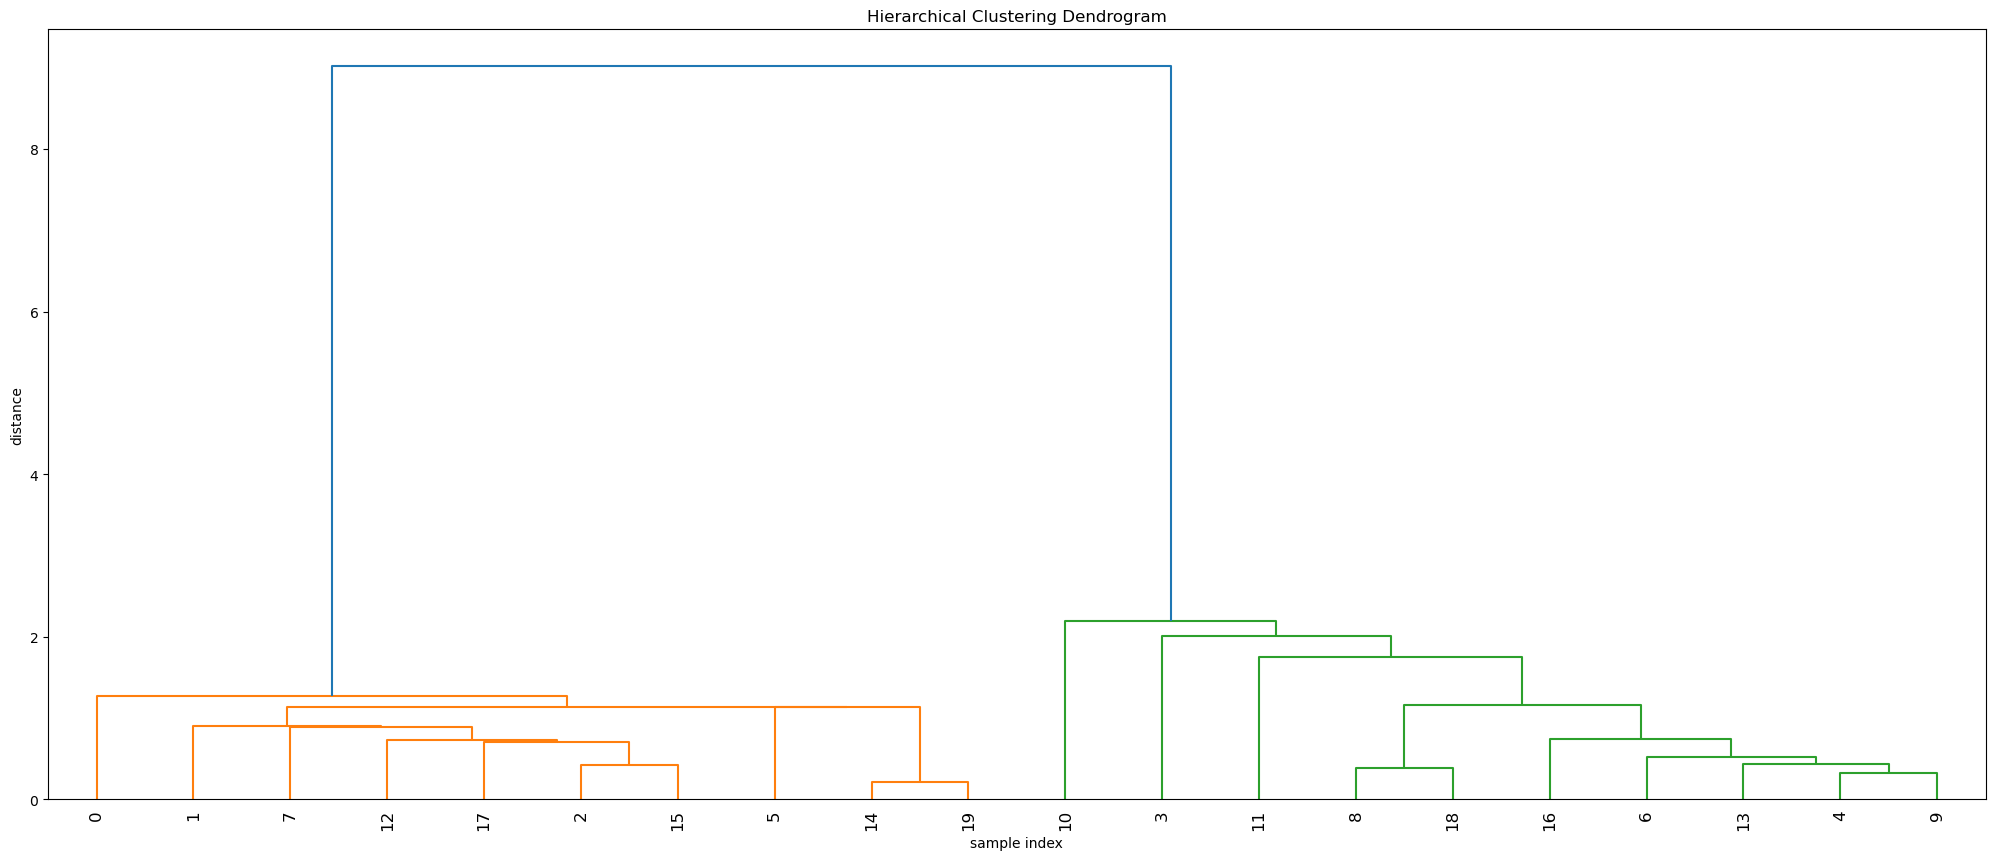

In [16]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z_single,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
)
plt.show()

### Form Clusters:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster

#### Set number of clusters or threshold distance. 

In [17]:
from scipy.cluster.hierarchy import fcluster

In [18]:
# split into three clusters
fcluster(Z_single, 3, criterion='maxclust')

array([1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1],
      dtype=int32)

In [19]:
# Threshold distance = 2.1; break all links longer than the threshold distance.
# Note that higher threshold distance corresponds to fewer clusters.
fcluster(Z_single, t=2.1, criterion='distance')

array([1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1],
      dtype=int32)

#### A better dendrogram function (re-used from the blog): 

In [20]:
def fancy_dendrogram(*args, **kwargs): 
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


# t is distance threshold to form number of clusters.  p is number of visualization slots (see example)
def distance_thr(Z,t,p): 
    plt.figure(figsize=(10,6))
    fancy_dendrogram(
        Z,
        truncate_mode='lastp',
        p=p,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,
        max_d=t,
    )
    plt.show()

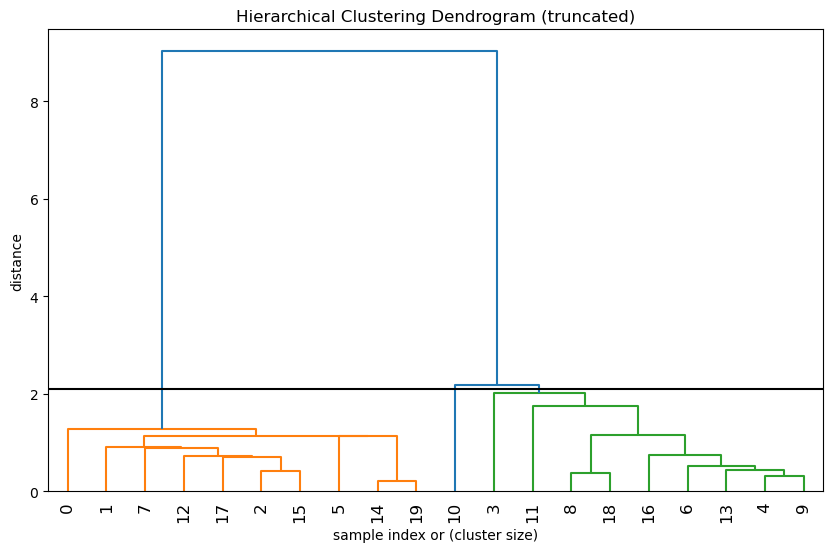

In [21]:
distance_thr(Z_single,t=2.1,p=20)

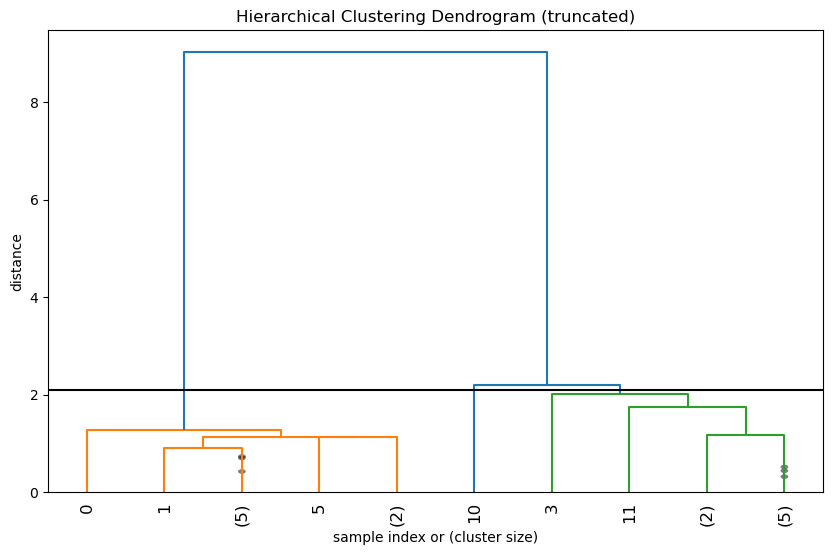

In [22]:
distance_thr(Z_single,t=2.1,p=10)

### Practice #2:

Try 'complete' linkage (and maybe other linkage metrics if you have time), and compare your results with the single linkage. Do these algorithms give you the same results?

In [23]:
# your code here


### Choosing the number of clusters:

There are numerous criteria for choosing the number of clusters.  See, for example:

https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

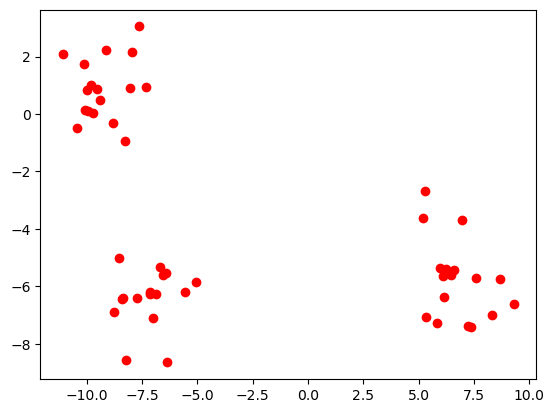

In [24]:
X, y = make_blobs(n_features=2, centers=3,n_samples=50,random_state=9999)
plt.scatter(X[:,0],X[:,1],c="r")
plt.show()

In [25]:
Z = linkage(X, 'single')

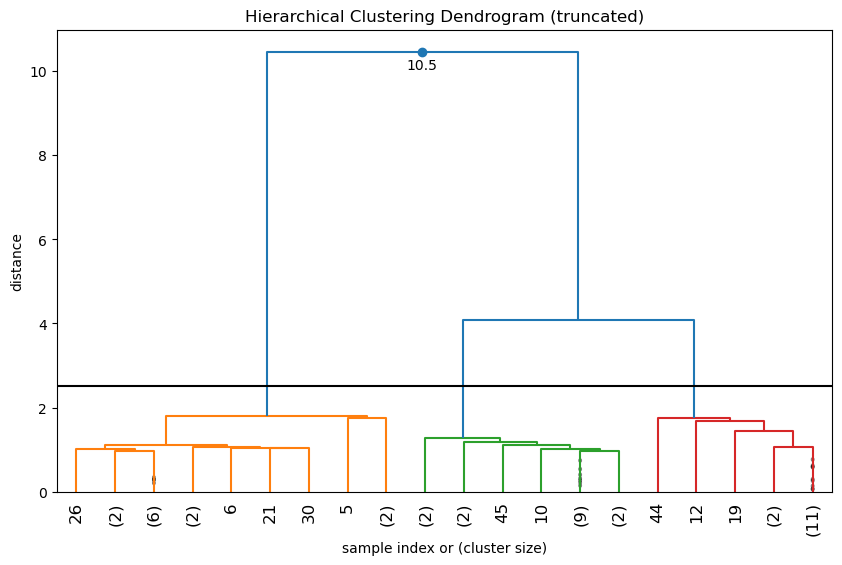

In [26]:
distance_thr(Z,t=2.5,p=20)

#### Silhouette Coefficient

One example of a metric used to choose number of clusters:

http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

For each sample, compute (b-a)/max(a,b), where:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

Then take the mean over all samples.

Larger silhouette score (closer to 1) = better clustering.

In [27]:
from sklearn.metrics import silhouette_score

# Choose a range of cluster numbers that you would like to evalulate:
range_n_clusters = range(2,10)
Z = linkage(X, 'single')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.740690680575255
For n_clusters = 3, the average silhouette_score is : 0.7807169246100848
For n_clusters = 4, the average silhouette_score is : 0.6532360724406461
For n_clusters = 5, the average silhouette_score is : 0.6070163847376033
For n_clusters = 6, the average silhouette_score is : 0.463120065630699
For n_clusters = 7, the average silhouette_score is : 0.46342650869848895
For n_clusters = 8, the average silhouette_score is : 0.3979054212478481
For n_clusters = 9, the average silhouette_score is : 0.24335983793902966


[598.7574693319061, 124.27011742883178, 99.60157269990653, 82.69998562366449, 66.9379832875384, 56.026602606127256, 46.691324182585916, 38.82171665326634]


/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/fengcharles/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

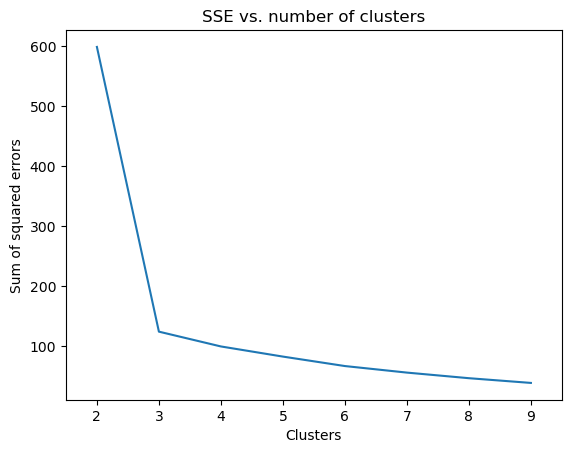

In [28]:
# As an alternative, look for an elbow in the within-cluster SSE (k-means example):
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(X)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.show()

## Leader Clustering 

Leader clustering will not be covered in this lab, but if you're interested you can see:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.leaders.html#scipy.cluster.hierarchy.leaders